# Custom modules

In [1]:
import os
import sys
sys.path.insert(1, '/home/mauricio/code/mcr/')

from mcr.ml.model_selection.multilabel import multilabel_sample_dataframe, multilabel_train_test_split, sample_report, split_report, sample_split_report
from mcr.ml import get_dummies_indices, reverse_dummies
from mcr.util import size, glimpse

# Standard data science modules

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('dark_background')

# Loading data

Sign up for an account on [DrivenData](http://www.drivendata.org/)  
Join the [Box-plots for education competition](https://www.drivendata.org/competitions/46/box-plots-for-education-reboot/)  
Download the competition datasets named `TrainingData.csv` and `TestData.csv`

In [3]:
df = pd.read_csv('/data/drivendata/TrainingData.csv', index_col=0)
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400277 entries, 134338 to 415831
Data columns (total 25 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Function                400277 non-null  object 
 1   Use                     400277 non-null  object 
 2   Sharing                 400277 non-null  object 
 3   Reporting               400277 non-null  object 
 4   Student_Type            400277 non-null  object 
 5   Position_Type           400277 non-null  object 
 6   Object_Type             400277 non-null  object 
 7   Pre_K                   400277 non-null  object 
 8   Operating_Status        400277 non-null  object 
 9   Object_Description      375493 non-null  object 
 10  Text_2                  88217 non-null   object 
 11  SubFund_Description     306855 non-null  object 
 12  Job_Title_Description   292743 non-null  object 
 13  Text_3                  109152 non-null  object 
 14  Text_4         

# Shuffling data

In machine learning theory, i.i.d. assumption is often made for training datasets to imply that all samples stem from the same generative process and that the generative process is assumed to have no memory of past generated samples.

To ensure observations are independent and don't follow any predefined sequence, the dataset is shuffled.

That's important when using the class `sklearn.model_selection.GridSearchCV` with k-fold cross-validation which doesn't resample the dataset as per the underlying class `sklearn.model_selection.StratifiedKFold(n_splits=5, shuffle=False, random_state=None)` doesn't shuffle data by default and that could lead to biased folds.

In [4]:
df = df.sample(frac=1, replace=False, random_state=1)

# Encoding labels as category types

In [5]:
LABELS = ['Function', 'Object_Type', 'Operating_Status', 'Position_Type', 'Pre_K', 'Reporting', 'Sharing', 'Student_Type', 'Use']
FEATURES = [feature for feature in df.columns if feature not in LABELS]
print('Memory before enconding: {} ({} deep)'.format(size(df.memory_usage().sum()), size(df.memory_usage(deep=True).sum())))
df[LABELS] = df[LABELS].apply(lambda x: x.astype('category'), axis=0)
print('Memory after enconding : {} ({} deep)'.format(size(df.memory_usage().sum()), size(df.memory_usage(deep=True).sum())))

Memory before enconding: 79.4 MiB (548.5 MiB deep)
Memory after enconding : 55.4 MiB (313.0 MiB deep)


# Converting labels in dummy variables

In [6]:
# Converting labels in dummy variables
y = pd.get_dummies(df[LABELS], prefix_sep='__')
y.info(memory_usage='deep')
y

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400277 entries, 129752 to 189020
Columns: 104 entries, Function__Aides Compensation to Use__Untracked Budget Set-Aside
dtypes: uint8(104)
memory usage: 42.8 MB


,Function__Aides Compensation,Function__Career & Academic Counseling,Function__Communications,Function__Curriculum Development,Function__Data Processing & Information Services,Function__Development & Fundraising,Function__Enrichment,Function__Extended Time & Tutoring,Function__Facilities & Maintenance,Function__Facilities Planning,...,Student_Type__Special Education,Student_Type__Unspecified,Use__Business Services,Use__ISPD,Use__Instruction,Use__Leadership,Use__NO_LABEL,Use__O&M,Use__Pupil Services & Enrichment,Use__Untracked Budget Set-Aside
129752,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
127683,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
265931,0,0,0,1,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
238935,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
253483,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
393068,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
359409,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
334609,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
326288,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0


# Test 0: trying to stratify split using sklearn's train_test_split()

In [7]:
# from sklearn.model_selection import train_test_split
# try:
#     X_train, X_test, y_train, y_test = train_test_split(df[FEATURES], y, test_size = 0.5, random_state=1, stratify=y)
# except ValueError as err:
#     print('ValueError:', err)

As pointed out in **_Groups of labels with less than 2 samples (unstratifiable)_**, the y population has class groups with less than 2 observations, thefore, the standard sklearn's `train_test_split()` won't work because of those cases.

# Test 1: Imbalanced split using sklearn's train_test_split(stratify=None)

Training size: 280193 (min_count: 22). Testing size: 120084 (min_count: 7)
Train ratio: 0.7670426099064663
Test ratio : 0.431510077694932


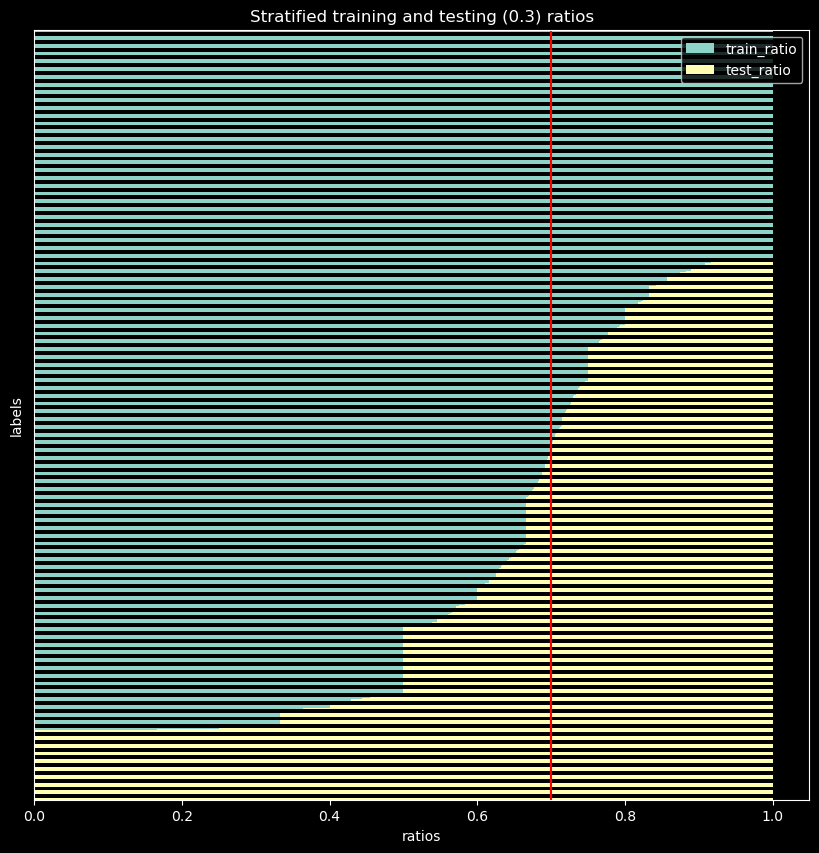

In [30]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df[FEATURES], y, test_size = .3, random_state=1, stratify=None)
print(f'Training size: {X_train.shape[0]} (min_count: {y_train.sum().min()}). Testing size: {X_test.shape[0]} (min_count: {y_test.sum().min()})')
print(f'Train ratio: {(y_train.value_counts() / y.value_counts()).mean()}')
print(f'Test ratio : {(y_test.value_counts() / y.value_counts()).mean()}')
_ = split_report(y, y_train, y_test, figsize=(10,10))

# Test 2: stratifying sample using multilabel_sample_dataframe()

In [31]:
for min_count in range(0,30):
    sampling = multilabel_sample_dataframe(df, y, size=0.7, min_count=min_count, seed=1)
    dummy_labels = pd.get_dummies(sampling[LABELS], prefix_sep='__')
    print(f'min_count given: {min_count} min_count taken: {dummy_labels.sum().min()} sample ratio: {(dummy_labels.value_counts() / y.value_counts()).mean()}')
# _ = sample_report(y, dummy_labels, figsize=(10,10))

min_count given: 0 min_count taken: 18 sample ratio: 0.7696485333319797
min_count given: 1 min_count taken: 21 sample ratio: 0.7718668281550514
min_count given: 2 min_count taken: 24 sample ratio: 0.771583325261738
min_count given: 3 min_count taken: 19 sample ratio: 0.7709453280616047
min_count given: 4 min_count taken: 22 sample ratio: 0.7707083207956503
min_count given: 5 min_count taken: 21 sample ratio: 0.7687145551837045
min_count given: 6 min_count taken: 23 sample ratio: 0.7722339626014724
min_count given: 7 min_count taken: 22 sample ratio: 0.7696337580241936
min_count given: 8 min_count taken: 22 sample ratio: 0.7756154273754484
min_count given: 9 min_count taken: 20 sample ratio: 0.769584559085949
min_count given: 10 min_count taken: 22 sample ratio: 0.7718715531537558
min_count given: 11 min_count taken: 22 sample ratio: 0.7720659460630157
min_count given: 12 min_count taken: 23 sample ratio: 0.7725594140556336
min_count given: 13 min_count taken: 24 sample ratio: 0.7757189

**Best sample ratio given min_count 29 and .7 sample:**

    min_count given: 29 min_count taken: 29 sample ratio: 0.7785994647898343

# Test 3: Stratified split using multi_train_test_split()

In [32]:
for min_count in range(0,30):
    X_train, X_test, y_train, y_test = multilabel_train_test_split(df[FEATURES], y, size=0.3, min_count=min_count, seed=1)
    y_train_ratio = (y_train.value_counts() / y.value_counts()).mean()
    y_test_ratio = (y_test.value_counts() / y.value_counts()).mean()
    print(f'min_count given: {min_count} train min_count: {y_train.sum().min()} test min_count: {y_test.sum().min()}', end=' ')
    print(f'train ratio: {y_train_ratio} test ratio : {y_test_ratio}', end=' ')
    print(f'difference: {y_train_ratio - y_test_ratio}')
# _= split_report(y, y_train, y_test, figsize=(10,10))

min_count given: 0 train min_count: 22 test min_count: 7 train ratio: 0.7732263950532569 test ratio : 0.42629060849963823 difference: 0.3469357865536186
min_count given: 1 train min_count: 18 test min_count: 11 train ratio: 0.7644794578582763 test ratio : 0.43759054505163597 difference: 0.32688891280664034
min_count given: 2 train min_count: 18 test min_count: 11 train ratio: 0.7731833219288907 test ratio : 0.43011865418240924 difference: 0.3430646677464815
min_count given: 3 train min_count: 20 test min_count: 9 train ratio: 0.7724233146256152 test ratio : 0.4285351509777641 difference: 0.3438881636478511
min_count given: 4 train min_count: 19 test min_count: 10 train ratio: 0.7671272417771067 test ratio : 0.43998515668731547 difference: 0.3271420850897912
min_count given: 5 train min_count: 18 test min_count: 11 train ratio: 0.7728878038368107 test ratio : 0.42817014452575963 difference: 0.34471765931105103
min_count given: 6 train min_count: 14 test min_count: 15 train ratio: 0.7717

**Best train ratio given min_count 0 and 70/30 split**

    min_count given: 0 train min_count: 22 test min_count: 7 train ratio: 0.7732263950532569 test ratio : 0.42629060849963823 difference: 0.3469357865536186

**Opposedly the best ratio difference given min_count 29 and 70/30 split**

    min_count given: 29 train min_count: 0 test min_count: 29 train ratio: 0.7576872671065363 test ratio : 0.44676212849950525 difference: 0.3109251386070311


# Test 4: Stratified split of a stratified sample

## Stratifying sample

In [26]:
for min_count in range(0,30):
    sampling = multilabel_sample_dataframe(df, y, size=0.7, min_count=min_count, seed=1)
    dummy_labels = pd.get_dummies(sampling[LABELS], prefix_sep='__')
    print(f'min_count given: {min_count} min_count taken: {dummy_labels.sum().min()} sample ratio: {(dummy_labels.value_counts() / y.value_counts()).mean()}')
# _ = sample_report(y, dummy_labels, figsize=(10,10))

min_count given: 0 min_count taken: 18 sample ratio: 0.7696485333319797
min_count given: 1 min_count taken: 21 sample ratio: 0.7718668281550514
min_count given: 2 min_count taken: 24 sample ratio: 0.771583325261738
min_count given: 3 min_count taken: 19 sample ratio: 0.7709453280616047
min_count given: 4 min_count taken: 22 sample ratio: 0.7707083207956503
min_count given: 5 min_count taken: 21 sample ratio: 0.7687145551837045
min_count given: 6 min_count taken: 23 sample ratio: 0.7722339626014724
min_count given: 7 min_count taken: 22 sample ratio: 0.7696337580241936
min_count given: 8 min_count taken: 22 sample ratio: 0.7756154273754484
min_count given: 9 min_count taken: 20 sample ratio: 0.769584559085949
min_count given: 10 min_count taken: 22 sample ratio: 0.7718715531537558
min_count given: 11 min_count taken: 22 sample ratio: 0.7720659460630157
min_count given: 12 min_count taken: 23 sample ratio: 0.7725594140556336
min_count given: 13 min_count taken: 24 sample ratio: 0.7757189

**Best sample ratio given min_count 29 and .7 sample:**

    min_count given: 29 min_count taken: 29 sample ratio: 0.7785994647898343

## Stratifying split of the stratified sample

In [27]:
sampling = multilabel_sample_dataframe(df, y, size=0.7, min_count=29, seed=1)
dummy_labels = pd.get_dummies(sampling[LABELS], prefix_sep='__')
for min_count in range(0,30):
    X_train, X_test, y_train, y_test = multilabel_train_test_split(sampling[FEATURES], dummy_labels, size=0.2, min_count=min_count, seed=1)
    y_train_ratio = (y_train.value_counts() / y.value_counts()).mean()
    y_test_ratio = (y_test.value_counts() / y.value_counts()).mean()
    print(f'min_count given: {min_count} train min_count: {y_train.sum().min()} test min_count: {y_test.sum().min()}', end=' ')
    print(f'train ratio: {y_train_ratio} test ratio : {y_test_ratio}', end=' ')
    print(f'difference: {y_train_ratio - y_test_ratio}')
    
#_ = sample_split_report(y, dummy_labels, y_train, y_test, figsize=(10,10))

min_count given: 0 train min_count: 26 test min_count: 3 train ratio: 0.666680715394999 test ratio : 0.2668984995824674 difference: 0.39978221581253154
min_count given: 1 train min_count: 24 test min_count: 5 train ratio: 0.6637021597384033 test ratio : 0.27769685749337825 difference: 0.38600530224502505
min_count given: 2 train min_count: 15 test min_count: 11 train ratio: 0.6617113923097776 test ratio : 0.2676450440770318 difference: 0.3940663482327458
min_count given: 3 train min_count: 22 test min_count: 7 train ratio: 0.6638011634142286 test ratio : 0.2713954109272953 difference: 0.39240575248693327
min_count given: 4 train min_count: 23 test min_count: 6 train ratio: 0.6596796861349067 test ratio : 0.27791320240780454 difference: 0.38176648372710215
min_count given: 5 train min_count: 22 test min_count: 7 train ratio: 0.6607898478360804 test ratio : 0.27331787211842506 difference: 0.38747197571765535
min_count given: 6 train min_count: 14 test min_count: 12 train ratio: 0.6608483

**Best train ratio given min_count 0 and 70/30 split of a .7 sample**

    min_count given: 0 train min_count: 26 test min_count: 3 train ratio: 0.666680715394999 test ratio : 0.2668984995824674 difference: 0.39978221581253154

**Opposedly the best ratio difference given min_count 29 and 70/30 split of a .7 sample**

    min_count given: 29 train min_count: 0 test min_count: 29 train ratio: 0.6541789167089964 test ratio : 0.28850642838934015 difference: 0.36567248831965626


Here we see that some testing labels are missing after splitting.  
It's required to simultaneously optimize the `size` and `min_count` parameters on either `multilabel_sample_dataframe` and `multilabel_train_test_split`, thus, balancing the stratification the best possible to achieve the best ratio.

# Optimize sampling and splitting parameters

Run the script `optimize-sample-split.py` to prepare data for analysis

In [13]:
# ! python optimize-sample-split.py

In [14]:
import pickle
if not os.path.isfile('/data/drivendata/optimize-sample-split.pkl'):
    print('Please run the optimize-sample-split.py')
else:
    with open('/data/drivendata/optimize-sample-split.pkl', 'rb') as f:
        results = pickle.load(f)
        display(glimpse(results))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100799 entries, 0 to 100798
Columns: 10 entries, sample_size to test_ratio
dtypes: float64(5), object(5)
memory usage: 21.0 MB


,field,non-null count,missing ratio,data type,unique count,unique preview
0,sample_lessfreq,100799,0.0,object,30,"[0, 1, 10, 11, 12, ..., 5, 6, 7, 8, 9]"
1,sample_min_count,100799,0.0,object,30,"[0, 1, 10, 11, 12, ..., 5, 6, 7, 8, 9]"
2,sample_ratio,100799,0.0,float64,541,"[0.06675592536155764, 0.07295573178258284, 0.0..."
3,sample_size,100799,0.0,float64,19,"[0.01, 0.01999999999999999, 0.03, 0.0399999999..."
4,test_lessfreq,100799,0.0,object,30,"[0, 1, 10, 11, 12, ..., 5, 6, 7, 8, 9]"
5,test_min_count,100799,0.0,object,30,"[0, 1, 10, 11, 12, ..., 5, 6, 7, 8, 9]"
6,test_ratio,100799,0.0,float64,100538,"[0.024211710155202838, 0.027255346978995582, 0..."
7,test_size,100799,0.0,float64,9,"[0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6,..."
8,train_lessfreq,100799,0.0,object,30,"[0, 1, 10, 11, 12, ..., 5, 6, 7, 8, 9]"
9,train_ratio,100799,0.0,float64,100538,"[0.016213462665645117, 0.017129853111320717, 0..."


## Metric

Best sample, train, test ratios

In [15]:
metrics = ['sample_size', 'sample_ratio', 'train_ratio', 'test_ratio']
display(results.sort_values(metrics, ascending=False).head(3).style.set_properties(**{'background-color': 'green'}, subset=metrics))
results.sort_values(metrics, ascending=False).tail(3).style.set_properties(**{'background-color': 'red'}, subset=metrics)

,sample_size,sample_min_count,sample_lessfreq,sample_ratio,test_size,test_min_count,train_lessfreq,test_lessfreq,train_ratio,test_ratio
5133,1.000000,19,29,1.000000,0.100000,3,22,7,0.927843,0.217250
7023,1.000000,26,29,1.000000,0.100000,3,22,7,0.927512,0.215472
6212,1.000000,23,29,1.000000,0.100000,2,24,5,0.927289,0.214517


,sample_size,sample_min_count,sample_lessfreq,sample_ratio,test_size,test_min_count,train_lessfreq,test_lessfreq,train_ratio,test_ratio
97582,0.010000,0,0,0.066756,0.700000,0,0,0,0.036745,0.060474
97583,0.010000,0,0,0.066756,0.800000,0,0,0,0.035214,0.061512
97584,0.010000,0,0,0.066756,0.900000,0,0,0,0.017565,0.066583


# Best parameters selection

* To allow cross-validation of 5 folds the minimal class frequency must be 5 for the training set and 1 for the test set.

In [16]:
k = 5
k_fold_condition = (results.train_lessfreq >= k) & (results.test_lessfreq >= 1) #& (results.train_lessfreq >= results.test_lessfreq)

* For begining the model, the selection should be:
    * The smallest sample size (e.g. 0.1)
    * The smallest test size (e.g. 0.1)
    * The best train ratios
* For finishing the model, the parameter set should have:
    * The full dataset
    * The smallest test size (e.g. 0.1)
    * best train ratios

## For 1% sample

In [17]:
ascending = [True, False, False, False]
results[k_fold_condition].sort_values(metrics, ascending=ascending).head(3).style.set_properties(**{'background-color': 'green'}, subset=metrics)

,sample_size,sample_min_count,sample_lessfreq,sample_ratio,test_size,test_min_count,train_lessfreq,test_lessfreq,train_ratio,test_ratio
100459,0.010000,28,28,0.145545,0.100000,0,22,1,0.139017,0.068591
100461,0.010000,28,28,0.145545,0.100000,2,21,3,0.137327,0.074610
100460,0.010000,28,28,0.145545,0.100000,1,21,1,0.135156,0.093377


## 10% sample

In [18]:
results[k_fold_condition & (results.sample_size>=0.1)
       ].sort_values(metrics, ascending=ascending).head(3).style.set_properties(**{'background-color': 'green'}, subset=metrics)

,sample_size,sample_min_count,sample_lessfreq,sample_ratio,test_size,test_min_count,train_lessfreq,test_lessfreq,train_ratio,test_ratio
62946,0.100000,28,28,0.250124,0.100000,0,23,1,0.232157,0.092049
62947,0.100000,28,28,0.250124,0.100000,1,23,2,0.230817,0.089238
62949,0.100000,28,28,0.250124,0.100000,3,23,5,0.230547,0.095275


## 20% sample

In [19]:
results[k_fold_condition & (results.sample_size>=0.19)
       ].sort_values(metrics, ascending=ascending).head(3).style.set_properties(**{'background-color': 'green'}, subset=metrics)

,sample_size,sample_min_count,sample_lessfreq,sample_ratio,test_size,test_min_count,train_lessfreq,test_lessfreq,train_ratio,test_ratio
58365,0.200000,28,28,0.357271,0.100000,0,26,1,0.336651,0.095655
58366,0.200000,28,28,0.357271,0.100000,1,26,2,0.334249,0.099641
58367,0.200000,28,28,0.357271,0.100000,2,25,3,0.333678,0.106211


## 30% sample

In [20]:
results[k_fold_condition & (results.sample_size>=0.2)
       ].sort_values(metrics, ascending=ascending).head(3).style.set_properties(**{'background-color': 'green'}, subset=metrics)

,sample_size,sample_min_count,sample_lessfreq,sample_ratio,test_size,test_min_count,train_lessfreq,test_lessfreq,train_ratio,test_ratio
53391,0.300000,28,28,0.450148,0.100000,3,24,4,0.420175,0.121831
53389,0.300000,28,28,0.450148,0.100000,1,27,1,0.419030,0.125206
53390,0.300000,28,28,0.450148,0.100000,2,21,4,0.418754,0.122319


## 50% sample

In [21]:
results[(results.train_lessfreq >= k) & (results.test_lessfreq >= 1) & (results.train_lessfreq > results.test_lessfreq) & (results.sample_size==0.5)
       ].sort_values(metrics, ascending=ascending).head(3).style.set_properties(**{'background-color': 'green'}, subset=metrics)

,sample_size,sample_min_count,sample_lessfreq,sample_ratio,test_size,test_min_count,train_lessfreq,test_lessfreq,train_ratio,test_ratio
42507,0.500000,29,29,0.620021,0.100000,0,27,2,0.578020,0.144577
42510,0.500000,29,29,0.620021,0.100000,3,23,6,0.576383,0.157208
42509,0.500000,29,29,0.620021,0.100000,2,22,6,0.576330,0.153578


## 60% sample

In [22]:
results[k_fold_condition & (results.sample_size==0.6)
       ].sort_values(metrics, ascending=ascending).head(3).style.set_properties(**{'background-color': 'green'}, subset=metrics)

,sample_size,sample_min_count,sample_lessfreq,sample_ratio,test_size,test_min_count,train_lessfreq,test_lessfreq,train_ratio,test_ratio
34070,0.600000,20,26,0.699567,0.100000,5,18,8,0.648227,0.161996
34067,0.600000,20,26,0.699567,0.100000,2,23,3,0.647990,0.175253
34065,0.600000,20,26,0.699567,0.100000,0,25,1,0.647182,0.166185


## 80% sample

In [23]:
results[k_fold_condition & (results.sample_size>=0.8)
       ].sort_values(metrics, ascending=ascending).head(3).style.set_properties(**{'background-color': 'green'}, subset=metrics)

,sample_size,sample_min_count,sample_lessfreq,sample_ratio,test_size,test_min_count,train_lessfreq,test_lessfreq,train_ratio,test_ratio
21726,0.800000,25,29,0.854414,0.100000,0,28,1,0.793677,0.192264
21727,0.800000,25,29,0.854414,0.100000,1,24,5,0.792206,0.191422
21729,0.800000,25,29,0.854414,0.100000,3,25,4,0.792142,0.202101


## For finishing the model

In [24]:
ascending = [False, False, False, False]
results[k_fold_condition
       ].sort_values(metrics, ascending=ascending).head(3).style.set_properties(**{'background-color': 'green'}, subset=metrics)

,sample_size,sample_min_count,sample_lessfreq,sample_ratio,test_size,test_min_count,train_lessfreq,test_lessfreq,train_ratio,test_ratio
5133,1.000000,19,29,1.000000,0.100000,3,22,7,0.927843,0.217250
7023,1.000000,26,29,1.000000,0.100000,3,22,7,0.927512,0.215472
6212,1.000000,23,29,1.000000,0.100000,2,24,5,0.927289,0.214517
